## PreProcess Images and feed into CNN

In [1]:
# Mount Google Drice
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!pip install pyrsgis

In [3]:
!git clone https://github.com/maxjonasbehrens/master_thesis_code
#%cd /content/master_thesis_code
#!git pull

Cloning into 'master_thesis_code'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 258 (delta 132), reused 176 (delta 78), pack-reused 0
Receiving objects: 100% (258/258), 607.65 KiB | 17.36 MiB/s, done.
Resolving deltas: 100% (132/132), done.


In [0]:
%load /content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import pyrsgis
import cv2
from skimage.transform import resize
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import scipy.io
import sklearn.model_selection

Warning! matplotlib_scalebar library not found.


In [0]:
# Import own module to preprocess images
import imp
sat_images = imp.new_module('sat_images')
exec(open("/content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py").read(), sat_images.__dict__)

## Test for one image

In [0]:
# Download test image from drive
img_path = "/gdrive/My Drive/nuts_night/BE34_2013.tif"

ds1, img = pyrsgis.raster.read(img_path)

In [0]:
# Print its shape
print("Image shape: ",img.shape)

Image shape:  (1299, 1482)


In [0]:
# Resize original image to compatible size
orig_img = np.swapaxes(img,0,-1)
orig_resized = resize(orig_img, (256,256))

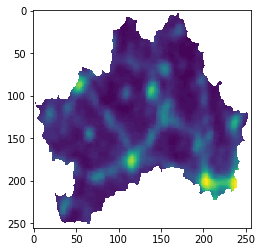

In [0]:
# Show the original image
plt.imshow(orig_resized, interpolation='nearest')
plt.show()

In [8]:
# Check the data frame
y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")
y_dat.head()

,nuts2,year,nuts_value,code,country,country_value,mean_value,diff_value
0,BE10,2008,61100.0,BE,Belgium,33100.0,31881.818182,28000.0
1,BE21,2008,39200.0,BE,Belgium,33100.0,31881.818182,6100.0
2,BE22,2008,27500.0,BE,Belgium,33100.0,31881.818182,-5600.0
3,BE23,2008,29400.0,BE,Belgium,33100.0,31881.818182,-3700.0
4,BE24,2008,34500.0,BE,Belgium,33100.0,31881.818182,1400.0


In [9]:
mae_diff = np.mean(abs(y_dat['diff_value']-y_dat['diff_value'].mean()))
print(mae_diff)

5478.004371660496


In [0]:
# List of all files in directory
mypath = "/gdrive/My Drive/nuts_night/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [0]:
# PreProcess images with certain resolution
res = 512
x,y,label = sat_images.create_data(onlyfiles,mypath,y_dat,prediction='diff_value',resolution=res,night=True)

Image processed:  0  of  692
Image processed:  10  of  692
Image processed:  30  of  692
Image processed:  40  of  692
Image processed:  50  of  692
Image processed:  60  of  692
Image processed:  70  of  692
Image processed:  80  of  692
Image processed:  90  of  692
Image processed:  100  of  692
Image processed:  110  of  692
Image processed:  120  of  692
Image processed:  130  of  692
Image processed:  140  of  692
Image processed:  150  of  692
Image processed:  160  of  692
Image processed:  170  of  692
Image processed:  180  of  692
Image processed:  190  of  692
Image processed:  200  of  692
Image processed:  210  of  692
Image processed:  220  of  692
Image processed:  230  of  692
Image processed:  240  of  692
Image processed:  250  of  692
Image processed:  260  of  692
Image processed:  270  of  692
Image processed:  280  of  692
Image processed:  290  of  692
Image processed:  300  of  692
Image processed:  310  of  692
Image processed:  320  of  692
Image processed:  

In [0]:
# Save ndarray to reproduce
scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_night_orig_512.mat", mdict={'x': x}, oned_as='row')

In [0]:
# Load input from scratch
#x = np.vstack((scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_day_orig_512_1.mat")['x'],scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_day_orig_512_2.mat")['x']))
x = scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_night_orig_512.mat")['x']
y, label = sat_images.create_y_label(onlyfiles,mypath,y_dat,prediction='nuts_value')

In [92]:
# Print shape of images
print('Shape of x: ',len(x))
print('Shape of y: ',len(y))
print('Shape of labels: ', len(label))

Shape of x:  692
Shape of y:  692
Shape of labels:  692


In [90]:
# Convert grayscale 1-channel to 3-channel
x = np.stack((x,)*3, axis=-1)
print(x.shape)

(692, 512, 512, 3)


## Create Train and Test Sets

In [93]:
# Create list of unique regions
regions = []
for i in range(len(label)):
  regions.append(label[i].rsplit('_',1)[0])

regions = np.unique(regions)
print(len(regions))

117


In [94]:
# Split regions into train and test set
msk_test = np.random.rand(len(regions)) < 0.2

train_split = regions[~msk_test]
test_split = regions[msk_test]

msk_val = np.random.rand(len(train_split)) < 0.25

val_split = train_split[msk_val]
train_split = train_split[~msk_val]
print(len(train_split))
print(len(val_split))
print(len(test_split))

69
23
25


In [95]:
# Split whole data set into test and train based on split regions
import math
label_train = []
label_val = []
label_test = []
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

# Split into train and test based on previous region split
for i in range(len(label)):
  if label[i].rsplit('_',1)[0] in train_split:
    if math.isnan(y[i]):
      pass
    else:
      label_train.append(label[i])
      x_train.append(x[i])
      y_train.append(int(y[i]))
  elif label[i].rsplit('_',1)[0] in val_split:
    if math.isnan(y[i]):
      pass
    else:
      label_val.append(label[i])
      x_val.append(x[i])
      y_val.append(int(y[i]))
  else:
    if math.isnan(y[i]):
      pass
    else:
      label_test.append(label[i])
      x_test.append(x[i])
      y_test.append(int(y[i]))

# Transform into numpy array
label_train = np.array(label_train)
label_test = np.array(label_test)
label_val = np.array(label_val)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)  
y_val = np.array(y_val)

# Print Shape
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)

(404, 512, 512)
(150, 512, 512)
(150,)
(138, 512, 512)


In [96]:
# Only execute when using night images, since they are 1d
x_train = np.array([x_train])
x_train = np.moveaxis(x_train,0,-1)
print(x_train.shape)
x_val = np.array([x_val])
x_val = np.moveaxis(x_val,0,-1)
print(x_val.shape)
x_test = np.array([x_test])
x_test = np.moveaxis(x_test,0,-1)
print(x_test.shape)

(404, 512, 512, 1)
(138, 512, 512, 1)
(150, 512, 512, 1)


In [97]:
# Normalise the data
x_train = (x_train/np.max(x_train))
x_test = (x_test/np.max(x_test))
x_val = (x_val/np.max(x_val))
print(np.max(x_train))

1.0


In [0]:
# Deep Model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=(512,512,1), activation='relu'))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(512, activation='relu',activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1,activation='relu'))

In [0]:
# Deep Model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(16, 3, padding='same', input_shape=(512,512,1), activation='relu'))
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='normal', activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1, kernel_initializer='normal',activation='relu'))

In [81]:
# Transfer Learning
base_model = tf.keras.applications.ResNet50V2(input_shape=(512,512,3),include_top=False)
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
preds=tf.keras.layers.Dense(units=1, activation = 'linear')(x)
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

94674944/94668760 [==============================] - 1s 0us/step


In [0]:
optim = tf.keras.optimizers.Adagrad(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optim, metrics=['mse','mae'], )

In [0]:
# Data Augmentation
training_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
# Data Preparation
batch_size = 10

# Define the data flow
training_generator = training_data_generator.flow(x_train,y_train,batch_size=batch_size)
validation_generator = validation_data_generator.flow(x_val, y_val,batch_size=batch_size)
test_generator = test_data_generator.flow(x_test,y_test,batch_size=1,shuffle=False)

In [148]:
# Calculate the number of steps
training_steps = training_generator.n/batch_size
validation_steps = validation_generator.n/batch_size

# Run the model
model.fit_generator(training_generator,
                    steps_per_epoch=training_steps,
                    epochs = 50,
                    validation_data = validation_generator,
                    validation_steps = validation_steps,
                    verbose = 1
                   )

Epoch 1/50
41/40 [==============================] - 18s 440ms/step - loss: 204278921.3168 - mean_squared_error: 204303952.0000 - mean_absolute_error: 10859.0977 - val_loss: 1037681254.4928 - val_mean_squared_error: 1032051776.0000 - val_mean_absolute_error: 25893.0039
Epoch 2/50
41/40 [==============================] - 8s 206ms/step - loss: 98226199.5166 - mean_squared_error: 96818176.0000 - mean_absolute_error: 7658.0098 - val_loss: 1037365600.0000 - val_mean_squared_error: 1031738816.0000 - val_mean_absolute_error: 25886.9727
Epoch 3/50
41/40 [==============================] - 8s 206ms/step - loss: 79405877.0573 - mean_squared_error: 79459144.0000 - mean_absolute_error: 6943.4795 - val_loss: 1054379144.3478 - val_mean_squared_error: 1031841856.0000 - val_mean_absolute_error: 25888.9941
Epoch 4/50
41/40 [==============================] - 8s 207ms/step - loss: 69793009.7822 - mean_squared_error: 69326784.0000 - mean_absolute_error: 6492.0464 - val_loss: 1042723482.8986 - val_mean_squar

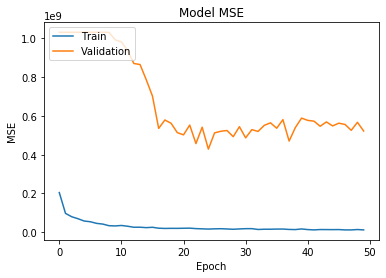

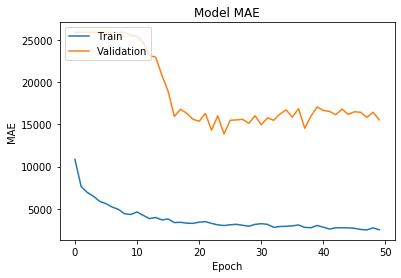

In [149]:
# Plot training & validation accuracy values
plt.plot(model.history.history['mean_squared_error'])
plt.plot(model.history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['mean_absolute_error'])
plt.plot(model.history.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [150]:
# Calculate the test performance
test_score = model.evaluate_generator(test_generator)
print('Test loss: '+str(test_score[0]))
print('Test MSE: '+str(test_score[1]))
print('Test MAE: '+str(test_score[2]))

Test loss: 176667666.44192484
Test MSE: 176667440.0
Test MAE: 9293.801
